# Feature Scaling

**Exercises** (in bold) involve running the code provided, examining the outputs, and answering the questions on the handout, which you will submit after you're done. These count towards your reading responses+in-class exercise grade. 

In [1]:
# setup:
import numpy as np
import urllib2
import matplotlib.pyplot as plt
%matplotlib inline

def load(url):
    """read a CSV from the web, return data and labels"""
    response = urllib2.urlopen(url)
    Xy = np.loadtxt(response, delimiter=',')
    y = Xy[:, -1]
    X = Xy[:, :-1]
    return X, y

from sklearn.neighbors import KNeighborsClassifier
def knn_predscore(trainX, trainy, testX, testy, k, metric='euclidean'):
    model = KNeighborsClassifier(n_neighbors=k,
                                metric=metric)

    model.fit(trainX, trainy)
    return model.score(testX, testy)

from sklearn.linear_model import Perceptron
def perceptron_predscore(trainX, trainy, testX, testy):
    model = Perceptron(n_iter=200)
    model.fit(trainX, trainy)
    return model.score(testX, testy)

Load the MNIST images as 784-dimensional vectors (each dim a pixel) as in PS1. Keep only 2 digits for binary classification.

In [2]:
trainXraw, trainyraw = load('http://cs.wellesley.edu/~sravana/ml/ps1/data/mnist1100/training.txt')
testXraw, testyraw = load('http://cs.wellesley.edu/~sravana/ml/ps1/data/mnist1100/testing.txt')
print 'Loaded training data', trainXraw.shape, trainyraw.shape, 'and testing data', testXraw.shape, testyraw.shape

Loaded training data (10000, 784) (10000,) and testing data (1000, 784) (1000,)


In [3]:
def load_2digits(c1, c2, trainXraw, trainyraw, testXraw, testyraw):
    """filter the full MNIST dataset to two digits for binary classification"""
    trainX = trainXraw[(trainyraw == c1) | (trainyraw == c2), :]
    trainy = trainyraw[(trainyraw == c1) | (trainyraw == c2)]

    testX = testXraw[(testyraw == c1) | (testyraw == c2), :]
    testy = testyraw[(testyraw == c1) | (testyraw == c2)]
    
    labelmap = {c1: -1, c2: +1}  # arbitrary assignment of +1 and -1 to the two classes
    for i, label in enumerate(testy):
        testy[i] = labelmap[label]
    for i, label in enumerate(trainy):
        trainy[i] = labelmap[label]
    
    print 'Loaded', trainy.size, 'training points and', testy.size, 'testing points for digits', c1, 'and', c2
    return trainX, trainy, testX, testy, labelmap

Let's consider two digits.

In [4]:
trainX, trainy, testX, testy, labelmap = load_2digits(8, 9, trainXraw, trainyraw, testXraw, testyraw)

Loaded 2000 training points and 200 testing points for digits 8 and 9


### Visualizing the mean images and w.

Let's visualize the "average" image in our training dataset.

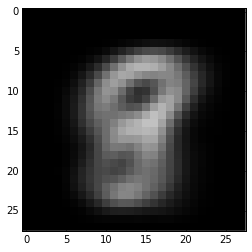

In [5]:
meanimg = np.mean(trainX, axis=0)  # get mean of each feature
# visualize mean image for fun
plt.imshow(meanimg.reshape(28, 28), interpolation='none', cmap = plt.get_cmap('gray'), vmin = 0, vmax = 255)

The following two cells visualize the average of *each* digit separately.

Visualizing 8 ( -1 )


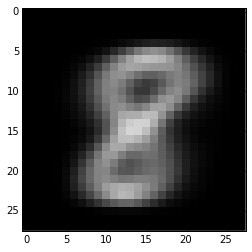

In [6]:
c1 = labelmap.keys()[0]
print 'Visualizing', c1, '(', labelmap[c1], ')'
meanc1 = np.mean(trainX[trainy==labelmap[c1], :], axis=0)
plt.imshow(meanc1.reshape(28, 28), interpolation='none', cmap = plt.get_cmap('gray'), vmin = 0, vmax = 255)

Visualizing 9 ( 1 )


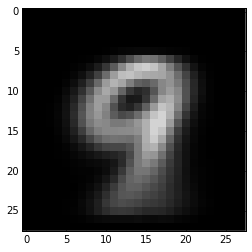

In [7]:
c2 = labelmap.keys()[1]
print 'Visualizing', c2, '(', labelmap[c2], ')'
meanc2 = np.mean(trainX[trainy==labelmap[c2], :], axis=0)
plt.imshow(meanc2.reshape(28, 28), interpolation='none', cmap = plt.get_cmap('gray'), vmin = 0, vmax = 255)

The weight vector learned by the perceptron to distinguish the 2 digits is itself a 784-dim vector, since the data lives in 784 dimensions. Just for fun, let us visualize it as an image!

**Exercise a**: According to the colorbar legend, green represents 0, red represents positive values, and blue negative. Why is the weight vector green around the boundaries?

<matplotlib.colorbar.Colorbar instance at 0x11b038878>

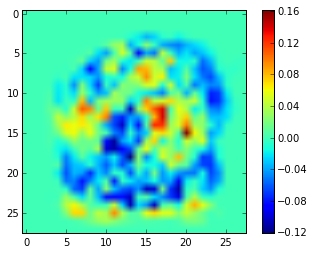

In [9]:
from numpy.linalg import norm

model = Perceptron(n_iter=200, fit_intercept=False)   # no bias fitting
model.fit(trainX, trainy)
w = model.coef_[0]
w/=norm(w, 2)  # normalize

plt.imshow(w.reshape(28, 28), cmap = plt.get_cmap('jet'), 
           vmin = np.min(w), vmax = np.max(w))
plt.colorbar()

### Prediction Baseline

**Exercise b:** Write down the resulting accuracies in the worksheet for future reference.

In [10]:
#trainX, trainy, testX, testy, labelmap = load_2digits(1, 9, trainXraw, trainyraw, testXraw, testyraw)
print 'kNN accuracy on original feature rep is', knn_predscore(trainX, trainy, testX, testy, 3)
print 'Perceptron accuracy on original feature rep is', perceptron_predscore(trainX, trainy, testX, testy)

kNN accuracy on original feature rep is 0.97
Perceptron accuracy on original feature rep is 0.955


## Experiment 1: Center and Variance-Scale the Features

### 1a: Centering

Compute the mean for each feature in the vector space.
Center the points by subtracting the mean.

$$f_{i, j}-\mu_j$$

Let's see what happens for a toy example in 2-d space.

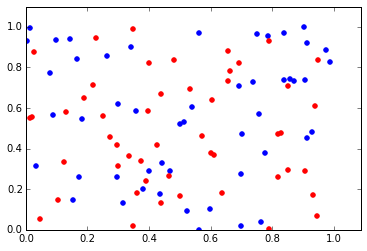

In [14]:
def scatterplot_labeledpoints(X, y):
    """plot 2-d points, colored with one of two labels (-1 or 1)"""
    plt.scatter(X[y==1, 0], X[y==1, 1], color='b')
    plt.scatter(X[y==-1, 0], X[y==-1, 1], color='r')
    plt.axis([min(0, min(X[:, 0])), max(X[:, 0])*1.1, min(0, min(X[:, 1])), max(X[:, 1])*1.1])
    plt.show()
    
# original points
toyX = np.random.rand(100, 2)   # 100 points in 2d
toyy = np.ones(100)
toyy[50:] = -1
scatterplot_labeledpoints(toyX, toyy)

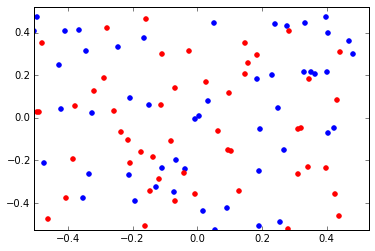

In [15]:
# after centering
meantoy = np.mean(toyX, axis=0)
centeredToyX = toyX - meantoy
scatterplot_labeledpoints(centeredToyX, toyy)

**Exercise c:** from the plots, how did the toy data change after centering?

Now let's see how centering affects classification accuracy on the MNIST digits. Remember that we're working with a binary dataset of two digits, so we can apply the perceptron.

In [16]:
centeredTrainX = trainX-meanimg
centeredTestX = testX-meanimg # can't use means of test data (or it would be cheating); must use training means
    
print 'kNN accuracy on centered feature rep is', knn_predscore(centeredTrainX, trainy, centeredTestX, testy, 3)

kNN accuracy on centered feature rep is 0.97


**Exercise d:** Explain why the kNN accuracy didn't change.

### 1b: Variance Normalization

Compute the standard deviation for each of the features and normalize each vector.

$$\dfrac{f_{i, j}}{\sigma_j}$$

Here's a toy data set where the two features are on different scales. One is between 50 and 75 and the other is between 0 and 100.

**Exercise e:** While this is a synthetic (randomly generated) dataset, you can imagine this happening in naturally occurring featurized data as well. If each datapoint represents a person, name 2 numerical features about a person (physical attributes, etc) that would be on different scales (50 to 75, 0 to 100)

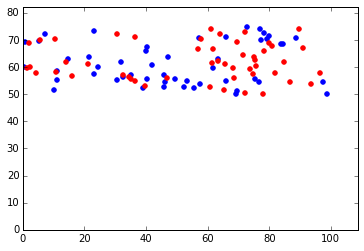

In [17]:
toyXvar = np.random.rand(100, 2)   # 100 points in 2d
toyXvar[:, 0]*=100
toyXvar[:, 1]*=25
toyXvar[:, 1]+=50

toyy = np.ones(100)
toyy[50:] = -1
scatterplot_labeledpoints(toyXvar, toyy)

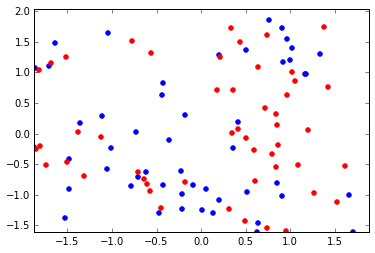

In [18]:
# after scaling and centering
stds = np.std(toyXvar, axis=0)
stdnormtoyXvar = (toyXvar-np.mean(toyXvar, axis=0))/stds
scatterplot_labeledpoints(stdnormtoyXvar, toyy)

**Excercise f:** How did the shape of the data change after centering and variance scaling? Observe the scales on the axes.

## Experiment 2: Example-Norm the Data-Points

**Note: this experiment will help you answer PS2 Q7, so observe it closely.**

Scale every data-point (row) by its Euclidean norm.

$$\dfrac{x}{||x||}$$

Here's the example from the slides of news articles in terms of number of mentions of "Wellesley" and "students". 

[[ 3 10]
 [13 34]
 [ 6  1]]


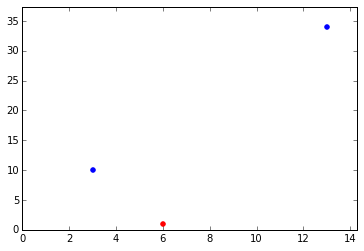

In [19]:
toyX2 = np.array([[3, 10], [13, 34], [6, 1]])
toyy2 = np.array([1, 1, -1])
print toyX2
scatterplot_labeledpoints(toyX2, toyy2)

Imagine we learned a hyperplane parameterized by `w=[-3, 1], b = 1`. Let's compute the distance of each of these point to the hyperplane.

In [20]:
w = np.array([-3, 1])
b = 1
for i, point in enumerate(toyX2):
    print point, 'with label', toyy2[i], 'lies at distance', w.dot(point) + b, 'from hyperplane'

[ 3 10] with label 1 lies at distance 2 from hyperplane
[13 34] with label 1 lies at distance -4 from hyperplane
[6 1] with label -1 lies at distance -16 from hyperplane


Now after normalizing each example:

[[ 0.28734789  0.95782629]
 [ 0.35713747  0.93405183]
 [ 0.98639392  0.16439899]]


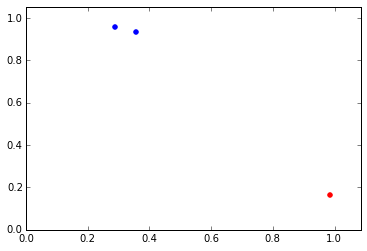

1.09578262852
0.862639436051
-1.79478278419


In [21]:
toyX2norms = norm(toyX2, axis=1, keepdims=True)
exnormToyX2 = toyX2/toyX2norms
print exnormToyX2
scatterplot_labeledpoints(exnormToyX2, toyy2)

for point in exnormToyX2:
    print w.dot(point) + b

In [22]:
for i, point in enumerate(exnormToyX2):
    print point, 'with label', toyy2[i], 'lies at distance', w.dot(point) + 1, 'from hyperplane'

[ 0.28734789  0.95782629] with label 1 lies at distance 1.09578262852 from hyperplane
[ 0.35713747  0.93405183] with label 1 lies at distance 0.862639436051 from hyperplane
[ 0.98639392  0.16439899] with label -1 lies at distance -1.79478278419 from hyperplane


What changed? 

## Experiment 3: Simpler Feature Design

Using every pixel's real value as feature may be redundant, and comes at the cost of slowing down our programs. Can we get away with simpler features?

### Binarize the Feature Values

Make every feature value in the MNIST data 0 or 1 by thresholding (remove grays).

In [23]:
binTrainX = np.zeros(trainX.shape)
binTrainX[trainX>50] = 1
binTestX = np.zeros(testX.shape)
binTestX[testX>50] = 1

In [24]:
print 'kNN accuracy on binarized feature rep is', knn_predscore(binTrainX, trainy, binTestX, testy, 3)
print 'Perceptron accuracy on binarized feature rep is', perceptron_predscore(binTrainX, trainy, binTestX, testy)

kNN accuracy on binarized feature rep is 0.975
Perceptron accuracy on binarized feature rep is 0.965


### Region-Based Feature Representations

Here's one simple way of featurizing the image using a small number of dimensions: represent the data points as R-dimensional vectors consisting of the number of black pixels in each of the R regions of the image. 

We divide up the image regions by flattening it into a 784-dimensional vector row-wise. Each block of 784/R pixels is a region.

Does this give us enough information for classification?

**Exercise g:** Try out a few different values of R to see how the accuracy changes. Can you beat the baseline?

In [25]:
def numblack(X, regions):
    Xregions = []
    dims = X.shape[1]
    for i in range(regions):
        if i==0:
            tmp = X[:, :dims/regions]
        else:
            tmp = X[:, dims*(i-1)/regions:dims*i/regions]
        Xregions.append(np.sum(tmp==0, axis=1))
    return np.vstack(tuple(Xregions)).T
    

In [48]:
R = 2
blackTestX = numblack(testX, R)
blackTrainX = numblack(trainX, R)
print 'kNN accuracy on ', R, 'dim feature rep is', knn_predscore(blackTrainX, trainy, blackTestX, testy, 3, 'euclidean')
print 'Perceptron accuracy on', R, 'dim feature rep is', perceptron_predscore(blackTrainX, trainy, blackTestX, testy)

kNN accuracy on  1400 dim feature rep is 0.975
Perceptron accuracy on 1400 dim feature rep is 0.955


**Exercise h:** Why might we want to featurize an image by regions rather than pixels? (There are two possible motives, name either one.)